# Pipeline

1. Preprocessing
2. Cosine Similarity / Nearest Neighbors
3. Scale / Standardize
4. Build / Test Models

## 1. Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [2]:
# read in data 
db_path = '../data/beer.db'
conn = sqlite3.connect(db_path)

query = "SELECT * FROM user_extract"
df = pd.read_sql(query, conn)

a. remove duplicates 

In [3]:
df = df[~df.duplicated()]

b. one-hot encode categorical variables

In [4]:
categorical_variables = ['beer_description', 'brewery']
for cat_var in categorical_variables:
    dummies = pd.get_dummies(df[cat_var], drop_first=True, prefix=cat_var)
    df = pd.merge(df, dummies, left_index=True, right_index=True)

c. flag outliers

In [5]:
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
skipnas = True

for feature in features:
    try:
        q1 = df[feature].quantile(.25)
        q3 = df[feature].quantile(.75)
        iqr = q3 - q1
        non_outlier_mask = (df[feature] >= q1 - 1.5*iqr) & (df[feature] <= q3 + 1.5*iqr)
        outliers = df[~non_outlier_mask]

        print("FEATURE {}".format(feature))
        print("num of outliers = {:,d}".format(len(outliers)))
        print("% of outliers = {:.2f}%".format(100*len(outliers)/len(df)))
        print("\n")
    except TypeError:
        print("FEATURE {}".format(feature))
        print("ANALYZING ALL NON-NA VALUES")
        
        non_nas = df[~df[feature].isna()][feature].astype(float)
        q1 = non_nas.quantile(.25)
        q3 = non_nas.quantile(.75)
        iqr = q3 - q1
        non_outlier_mask = (non_nas >= q1 - 1.5*iqr) & (non_nas <= q3 + 1.5*iqr)
        outliers = non_nas[~non_outlier_mask]
        print("num of outliers = {:,d}".format(len(outliers)))
        print("% of outliers = {:.2f}%".format(100*len(outliers)/len(non_nas)))
        print("\n")

FEATURE ABV
num of outliers = 3,421
% of outliers = 3.33%


FEATURE global_rating
num of outliers = 3,648
% of outliers = 3.56%


FEATURE user_rating
num of outliers = 11,267
% of outliers = 10.98%


FEATURE IBU
ANALYZING ALL NON-NA VALUES
num of outliers = 557
% of outliers = 1.00%




C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\tomsharp\AppData\Local\Continuum\miniconda3\envs\ml_guild\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi

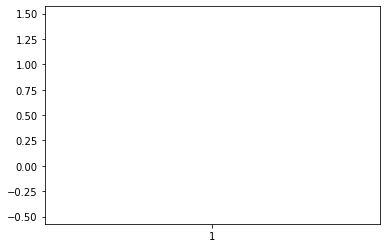

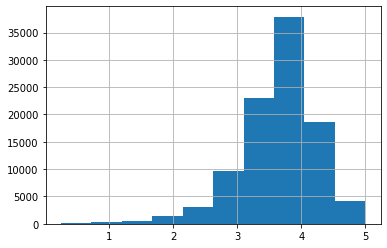

In [6]:
plt.boxplot(df['user_rating'])
plt.show()
df['user_rating'].hist()

d. Impute missing values

In [7]:
features = ['ABV', 'global_rating', 'user_rating', 'IBU']
impute_method = 'mean'

for feature in features:
    if impute_method == 'mean':
        non_nas = df[~df[feature].isna()][feature].astype(float)
        feature_mean = non_nas.mean()
        df[feature] = df[feature].fillna(feature_mean)

## 2. Cosine Similarity / Nearest Neighbors

a. Create User-Item Matrix 

In [8]:
# User Specified Fill Method
fill_method = 0

In [9]:
# Create User-Item Matrix 
data = df
values = 'user_rating'
index = 'username'
columns = 'beer_name'
agg_func = 'mean'

if fill_method == 'item_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix = ui_matrix.fillna(ui_matrix.mean(axis=0), axis=0)

elif fill_method == 'user_mean':
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func)
    ui_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

elif fill_method == 0:
    ui_matrix = pd.pivot_table(data=data, values=values, index=index, 
                               columns=columns, aggfunc=agg_func, fill_value=0)
else:
    raise ValueError("Please checkout 'fill_method' value")

ui_matrix.columns = list(ui_matrix.columns)

ui_matrix.head()

,!Wild Blend! (Morango+Amora),"""33"" Export","""Body"" System","""British Bitter"" English Pale Ale","""Calcium"" Blood Orange","""Craft Beer"" Dark Lager Dry Hopped Oct. 2017","""Cream Soda"" Wheat IPA","""Cult of Pekko"" Hop-Scotch IPA (2017)","""K"" is for Kriek","""Not Just Some"" Oatmeal Stout",...,分 桃 (Fēn Táo),分 桃 (Fēn Táo) (Blend 2),废都 (Two Lost Capitals),日本から来たネコ (Some Cat From Japan),日本で人気がある Big In Japan DDH IPA,木島平村 Hard Cider #39,藻細工S-IPA (mosaic S-IPA),調和,黄雪 (おうせき) - Yellow Snow,광화문 Seoulite Ale
username,,,,,,,,,,,,,,,,,,,,,
AFernan25,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
AlexKress,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
Asier05,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
Audyoh,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0
Boat,4,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,...,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0


b. Scale / Standardization

In [10]:
## User Specified Scale / Standardization Method
# scale_standardize = None

In [11]:
# # Scale / Standardize 
# if scale_standardize == 'scale':
#     print('Data is already scaled from 0 to 5')
# elif scale_standardize == 'standardize':
#     from sklearn.preprocessing import StandardScaler
#     scaler = StandardScaler()
#     standardized_ui_matrix = pd.DataFrame(scaler.fit_transform(ui_matrix))
#     standardized_ui_matrix.index = ui_matrix.index
#     standardized_ui_matrix.columns = ui_matrix.columns
#     ui_matrix = standardized_ui_matrix
# elif scale_standardize == None:
#     print("Skipping scaling / standardization")
# else:
#     raise ValueError("Please checkout 'scale_standardize' value")

c. Calculate Cosine Similarity

In [12]:
# Calculate Cosine Similarity 
user_of_reference = 'tsharp93'
print("User of Reference for Cosine Sim = {}".format(user_of_reference))

from sklearn.metrics.pairwise import cosine_similarity
X = ui_matrix[ui_matrix.index == user_of_reference]
Y = ui_matrix[ui_matrix.index != user_of_reference]

sim = cosine_similarity(X,Y)[0].tolist()
names = Y.index

sim_df = pd.DataFrame({'username':names, 'sim_score':sim})
sim_df = sim_df.sort_values(by='sim_score', ascending=False)

User of Reference for Cosine Sim = tsharp93


In [13]:
sim_df.head()

,username,sim_score
110,r4ymond,0.059821
82,edufontanez,0.054202
0,AFernan25,0.051696
15,FernandoRamirez,0.049640
103,mikeyjimenez,0.048229


d. Add Nearest Neighbor (Cosine Sim) Rank to Data

In [14]:
# add neighbor rank to df
neighbor_rank = sim_df.reset_index(drop=True)
neighbor_rank.index.name = 'nearest_neighbor_rank'
neighbor_rank.reset_index(inplace=True)
neighbor_rank['nearest_neighbor_rank'] = neighbor_rank['nearest_neighbor_rank'] + 1
neighbor_rank = neighbor_rank[['nearest_neighbor_rank', 'username']]

In [15]:
neighbor_rank.head()

,nearest_neighbor_rank,username
0,1,r4ymond
1,2,edufontanez
2,3,AFernan25
3,4,FernandoRamirez
4,5,mikeyjimenez


In [16]:
print(df.shape)
df = pd.merge(neighbor_rank, df, on='username')
print(df.shape)

(102598, 8347)
(102558, 8348)


## 3. Scale / Standardize Data 

#### Select Features and Target

In [17]:
brewery_cols = [col for col in df if col.startswith('brewery_')]
beer_description_cols = [col for col in df if col.startswith('beer_description_')]

features = ['ABV', 'IBU', 'global_rating'] + beer_description_cols
target = 'user_rating'

print("REMINDER User of Reference = {}".format(user_of_reference))

REMINDER User of Reference = tsharp93


#### Transform Features and Target Separately (easier to Inverse Transform later)

In [18]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_scaler.fit(df[features])
X_scaled = X_scaler.transform(df[features])

y_scaler = StandardScaler()
y_scaler.fit(np.array(df[target]).reshape(-1,1))
y_scaled = y_scaler.transform(np.array(df[target]).reshape(-1,1))

## 4. Build Models

#### Set Up Estimators and Grids

In [19]:
# empty estimator dictionary
estimator_dict = {}


# import GridSearchCV and desired estimators
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.svm import SVR


# create models and grids 
estimator = Lasso()
grid = {
    'fit_intercept': [False],
    'normalize': [False]
}
estimator_dict['elasticnet'] = {'estimator':estimator, 'grid':grid}


estimator = ElasticNet()
grid = {
    'fit_intercept': [False],
    'normalize': [False]
}
estimator_dict['elasticnet'] = {'estimator':estimator, 'grid':grid}


# estimator = SVR()
# grid = {
#     'epsilon': np.linspace(0.25/2, 0.5, 10),
#     'C': np.linspace(1.0, 10, 10),
#     'fit_intercept': [True, False],
#     'max_iter': [10000]
# }

estimator_dict['linearsvr'] = {'estimator':estimator, 'grid':grid}

####  Set Scoring Metric

In [20]:
scoring = 'neg_mean_absolute_error'

#### Train/Test Function

In [21]:
def multiple_gridsearchCV(estimator_dict, X_train, y_train):
    
    # grid search for each estimator, store best params and scores for each estimator
    for key in estimator_dict.keys():
        
        # build gridsearchcv
        gridsearchcv = GridSearchCV(estimator = estimator_dict[key]['estimator'], 
                                    param_grid = estimator_dict[key]['grid'],
                                    cv=3, scoring=scoring, return_train_score=True, iid=True)

        # silence SVR convergence warnings 
        import warnings
        warnings.filterwarnings('ignore', 'Liblinear failed to converge,*')

        # fit gridsearchcv
        gridsearchcv.fit(X_train, y_train)

        # gather results 
        estimator_dict[key]['nearest_neighbors'] = 'ALL'
        estimator_dict[key]['n_training_points'] = len(X_train)
        estimator_dict[key]['best_params'] = gridsearchcv.best_params_
        estimator_dict[key][scoring] = gridsearchcv.best_score_
        estimator_dict[key]['stdev'] = gridsearchcv.cv_results_['std_test_score'][gridsearchcv.best_index_]
        
        results_dict = estimator_dict

    return(results_dict)

#### B. Take Top *N* Nearest Neighbors

In [23]:
# specify top_n range
top_n = 5

Prep Data by Methodology

In [24]:
# take top_n nearest neighbors
df_top_n = df[df['nearest_neighbor_rank'] <= top_n]

# store training data 
training_data = df_top_n
print(len(training_data))

1175


Train / Test

In [29]:
# split data
X_train = training_data[training_data['username'] != user_of_reference][features]
y_train = training_data[training_data['username'] != user_of_reference][target]

# train
results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# append results


View Results

In [30]:
results_dict

{'elasticnet': {'estimator': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
             max_iter=1000, normalize=False, positive=False, precompute=False,
             random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
  'grid': {'fit_intercept': [False], 'normalize': [False]},
  'nearest_neighbors': 'ALL',
  'n_training_points': 1175,
  'best_params': {'fit_intercept': False, 'normalize': False},
  'neg_mean_absolute_error': -0.5552952474563988,
  'stdev': 0.05122499457871815},
 'linearsvr': {'estimator': ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
             max_iter=1000, normalize=False, positive=False, precompute=False,
             random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
  'grid': {'fit_intercept': [False], 'normalize': [False]},
  'nearest_neighbors': 'ALL',
  'n_training_points': 1175,
  'best_params': {'fit_intercept': False, 'normalize': False},
  'neg_mean_absolute_error': -0.55

#### C. Sort by Nearest Neigbors, Take Top *n_points*

In [26]:
# specify n_points
n_points = 10000

Prep Data by Methodology 

In [27]:
# sort by nearest neighbors
df_sorted = df.sort_values('nearest_neighbor_rank')

# take top n_points of sorted df
df_sorted_top_n = df_sorted.iloc[:n_points, ]

# store training data 
training_data = df_sorted_top_n

Train / Test

In [28]:
# split data
X_train = training_data[training_data['username'] != user_of_reference][features]
y_train = training_data[training_data['username'] != user_of_reference][target]

# train
results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# append results
results_df = pd.DataFrame.from_dict(results_dict, orient='index')[['nearest_neighbors', 'n_training_points', 
                                                   'best_params', 'neg_mean_squared_error']]
all_results_df = all_results_df.append(results_df)

KeyboardInterrupt: 

View Results

In [ ]:
all_results_df

In [ ]:
training_data.head()

#### D. Subset by Users w/ >= *min_ppu*, Take Top *N* Nearest Neighbors

In [58]:
# subset df by users with min_ppu (points per user)
min_ppu = 500

Prep Data by Methodology

In [ ]:
v = df['nearest_neighbor_rank'].value_counts()
df[df['nearest_neighbor_rank'].isin(v.index[v.gt(5)])]

In [65]:
df.groupby('username').count()['nearest_neighbor_rank'] >= min_ppu

username
AFernan25           False
AlexKress           False
Asier05              True
Audyoh              False
Boat                 True
Brazilian_Bob        True
Captain_zhopa        True
CapteinAwsome        True
ClemsMan            False
Damgero             False
DangarMan            True
Davidnorman         False
Edufernandez         True
ElinFN              False
Fear_the_Beerd      False
FernandoRamirez     False
Florindobucci       False
Fujimike            False
Gmlman              False
Hanzz87             False
Hariseldon38         True
Heidistrand         False
IkebanaSushiBars     True
JandMDAD             True
Jazzparanoia        False
JustinX03            True
Justinswaldrip      False
Leirah               True
LezzieBorden        False
Lookaszk            False
                    ...  
kwitnes             False
marcosten           False
marcusSRG            True
mat___              False
mattiasholm          True
mikeyjimenez         True
nootjam              True
nun

In [ ]:
n_points = 10000

# take top n_points of sorted df
df_sorted_top_n = df_sorted.iloc[:n_points,]

Train / Test

In [ ]:
# split data
X_train = training_data[training_data['username'] != user_of_reference][features]
y_train = training_data[training_data['username'] != user_of_reference][target]

# train
results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# append results
results_df = pd.DataFrame.from_dict(results_dict, orient='index')[['nearest_neighbors', 'n_training_points', 
                                                   'best_params', 'neg_mean_squared_error']]
all_results_df = all_results_df.append(results_df)

View Results

In [ ]:
all_results_df

#### Results

In [56]:
all_results_df['rmse'] = np.sqrt(-all_results_df['neg_mean_squared_error'])

In [57]:
all_results_df

,nearest_neighbors,n_training_points,best_params,neg_mean_squared_error,rmse
elasticnet,ALL,39.0,"{'alpha': 0.5, 'fit_intercept': True, 'l1_rati...",-0.421290,0.649068
linearsvr,ALL,39.0,"{'C': 2.0, 'epsilon': 0.25, 'fit_intercept': T...",-0.519576,0.720816
elasticnet,ALL,39.0,"{'alpha': 0.5, 'fit_intercept': True, 'l1_rati...",-0.421290,0.649068
linearsvr,ALL,39.0,"{'C': 2.0, 'epsilon': 0.25, 'fit_intercept': T...",-0.519576,0.720816


#### A. All Data

In [20]:
# # store training data 
# training_data = df

In [21]:
# # split data
# X_train = training_data[training_data['username'] != user_of_reference][features]
# y_train = training_data[training_data['username'] != user_of_reference][target]

# # train
# results_dict = multiple_gridsearchCV(estimator_dict, X_train, y_train)

# # append results
# results_df = pd.DataFrame.from_dict(results_dict, orient='index')[['nearest_neighbors', 'n_training_points', 
#                                                    'best_params', 'neg_mean_squared_error']]
# all_results_df = all_results_df.append(results_df)